In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.signal
import keras
import ipywidgets as widgets

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from PIL import Image

# Introduction
For this project, we decided to work on an image classification problem using neural networks to solve multi-label classification. Initially, we began by researching different datasets and deciding on a dataset which was generic (not affiliated with any existing IPs) and contained multi-labels.

## The Data
We chose to work on creating a model to classify low-resolution game sprites. For this, we went with the [Pixel Art dataset by Ebrahim Elgazar](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art). This provides us with a set of 595 sprites to look at.

*For some reason, the original dataset is actually 89,000 images of the same 894 sprites. But, indices from 244 to 543 are downscaled images, so we didn't want to work on those. That leaves use with 595 sprites to work on*

In [21]:
data = np.load('./Dataset1/sprites_labels.npy')
sprites = np.load('./Dataset1/sprites.npy')

y = data[:894]
y = np.delete(y, slice(244, 543), axis=0)
print(y.shape)

X = sprites[:894]
X = np.delete(X, slice(244, 543), axis=0)
print(X.shape)

unique, counts = np.unique(y, return_counts=True, axis=0)
for i in range(len(unique)):
    print(unique[i], counts[i])

(595, 5)
(595, 16, 16, 3)
[0. 0. 0. 0. 1.] 80
[0. 0. 0. 1. 0.] 350
[0. 0. 1. 0. 0.] 60
[0. 1. 0. 0. 0.] 25
[1. 0. 0. 0. 0.] 80


The labels for said data are as follows:
[Character (Front), Monster, Food, Item, Character (Side)]
- Characters (0-159)
    - [1, 0, 0, 0 ,0] - Front Facing
    - [0, 0, 0, 0, 1] - Side Facing
- Monsters (160-183)
    - [0, 1, 0, 0, 0]
- Food (184-243)
    - [0, 0, 1, 0, 0]
- Downscaled Monsters - RED (244-343) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - GREEN (344-443) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - BLUE (444-543) *excluded*
    - [0, 1, 0, 0, 0]
- Items (544-893)
    - [0, 0, 0, 1, 0]

Conveniently, the labels are already in one-hot-encoding form.

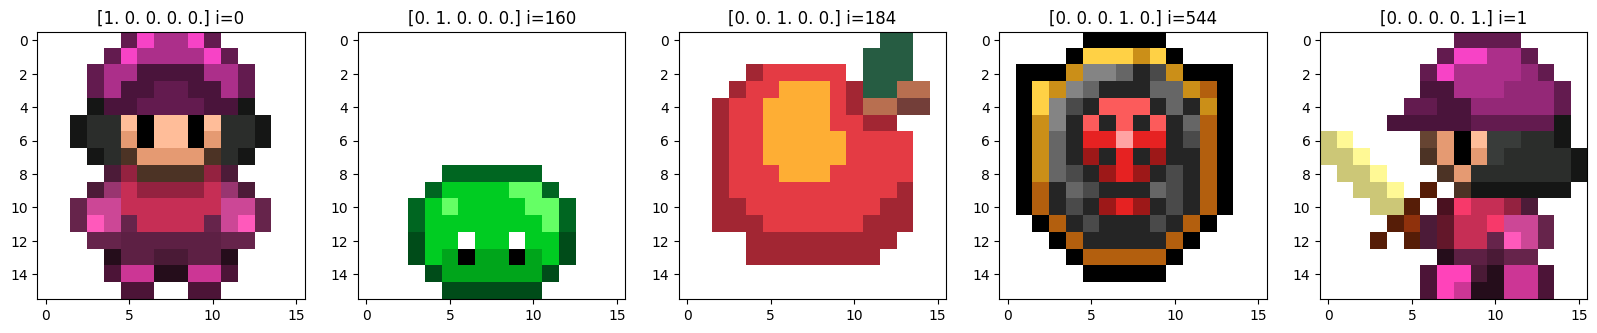

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
indices = [0, 160, 184, 544, 1]
for i in range(5):
    index = indices[i]
    ax[i].imshow(X[index])
    ax[i].set_title(f"{y[index]} i={index}")

By displaying the averages for each label, we can get an idea of common elements for each type:

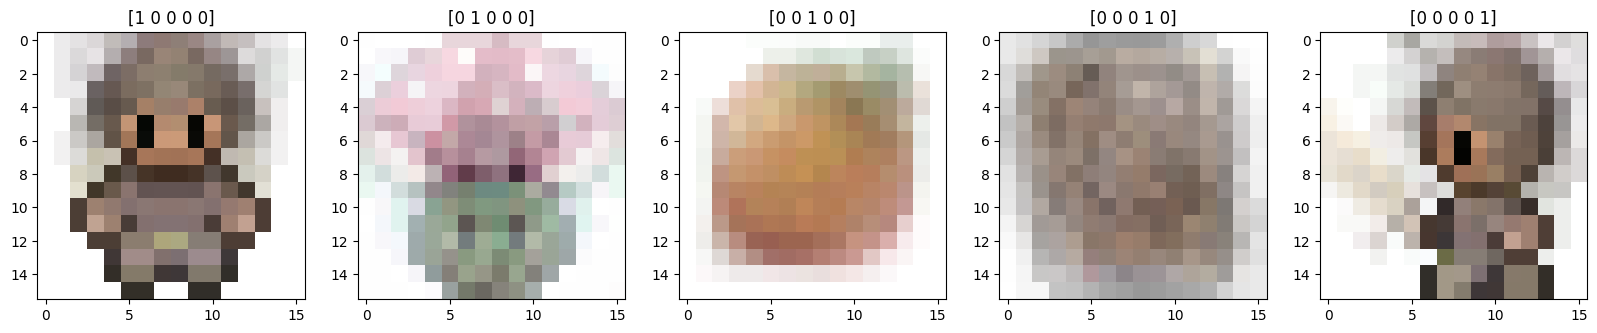

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

labels = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

for i in range(5):
    mask = np.all(y == labels[i], axis=1)
    average = np.sum(X[mask], axis=0) / np.sum(mask)
    average /= 255
    
    ax[i].imshow(average)
    ax[i].set_title(str(labels[i]))

As seen above, the sprites for characters have very strong features that are similar to eachother.

# Building the Model


In [ ]:
# (80:20):20 splitting for training, validation, and testing respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True, stratify=y_train)

*A demonstration of what convolution can do to our dataset to reveal features*

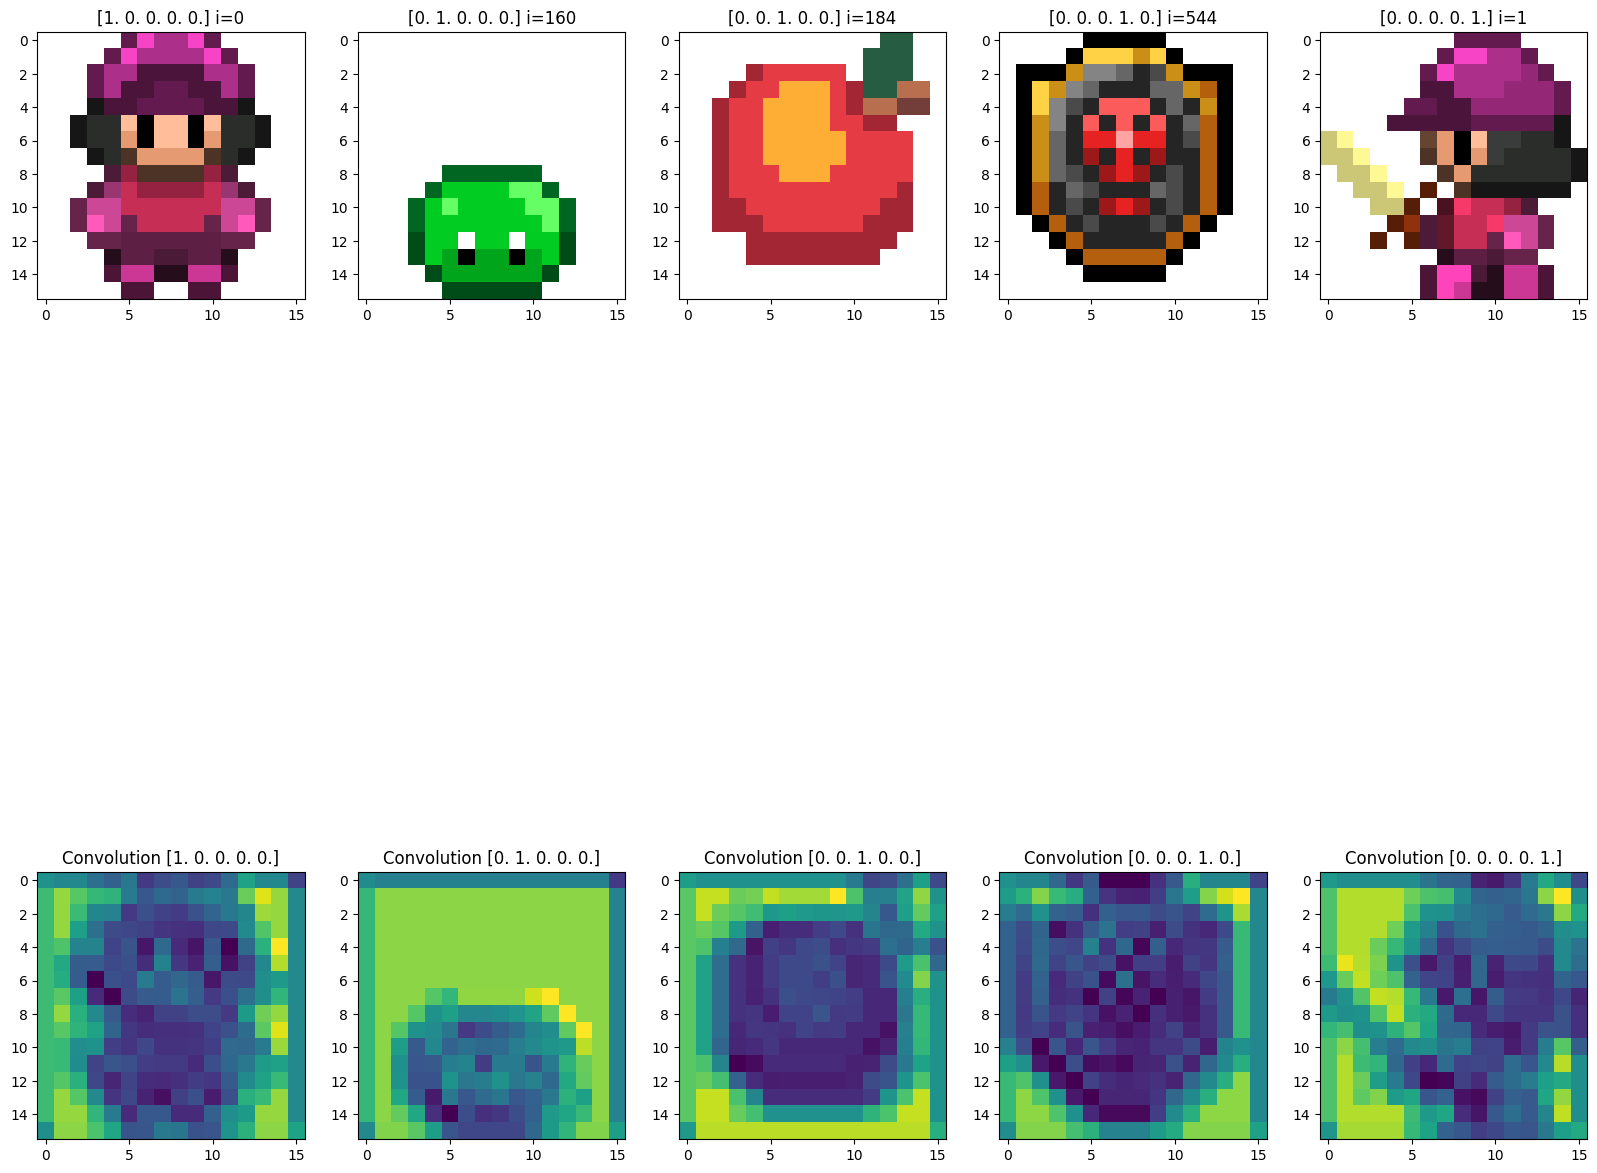

In [48]:
indices = [0, 160, 184, 544, 1]
example_sprites = np.array(X[indices])
conv_layer = keras.layers.Conv2D(1, (3, 3), input_shape=(16, 16, 1), activation='relu', padding='same')

fig, ax = plt.subplots(2, 5, figsize=(20, 20))
for i in range(5):
    ax[0, i].imshow(example_sprites[i])
    ax[0, i].set_title(f"{y[indices[i]]} i={indices[i]}")
    conv_result = conv_layer(np.expand_dims(example_sprites[i], axis=0))
    ax[1, i].imshow(conv_result[0])
    ax[1, i].set_title(f"Convolution {y[indices[i]]}")

We built our model builder function to be thourough with many different approaches to sort out our neural network.

In [ ]:
def create_model():
    pass

# A Little Demonstration
Here, I've added a widget to play with to see the results of our model.

In [ ]:
import ipywidgets as widgets
label_names = ['Character (FORWARD)', 'Monster', 'Food', 'Item', 'Character (SIDE)']
index_slider = widgets.IntSlider(value=0, min=0, max=len(X_test)-1, description='Image index:')
def show_image(index):
    plt.imshow(X_test[index])
    plt.show()
    prediction = probability_model(X_test[index:index+1]).numpy()
    print(f'Predicted label: {np.argmax(prediction)} ({label_names[np.argmax(prediction)]})')
    print(f'Actual label:    {np.argmax(y_test[index])} ({label_names[np.argmax(y_test[index])]})')
    print('Predicted probabilities:')
    print(f'    Character (FORWARD): {'%.2f' % (prediction[0][0] * 100)}%')
    print(f'    Monster:             {'%.2f' % (prediction[0][1] * 100)}%')
    print(f'    Food:                {'%.2f' % (prediction[0][2] * 100)}%')
    print(f'    Item:                {'%.2f' % (prediction[0][3] * 100)}%')
    print(f'    Character (SIDE):    {'%.2f' % (prediction[0][4] * 100)}%')
widgets.interactive(show_image, index=index_slider)

# Conclusion & Hindsight
After working through this, the dataset we chose could have been more interesting. This dataset is fairly small, and doesn't have all that much diversity. However, this project has been pretty interesting in terms of being able to observe, learn, and discuss machine learning techniques